## Articulation points and bridges

In [4]:
import bisect

import networkx as nx
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

import config
from config import GRAPHS_PATH
from lib.graph_database_access import get_pathways
from lib.networks import get_interactomes, get_multiindex

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory: c:\git\pathwayanalysisplatform\proteoformnetworks


In [5]:
index = get_multiindex()
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(GRAPHS_PATH)
interactomes = [*interactomes_no_sm.values(), *interactomes_with_sm.values(), *interactomes_with_unique_sm.values()]

In [14]:
import decimal
from statistics import mean

columns = [
    "Number of Articulation Points",
    "Percentage of nodes that are articulation points",
    "Number of accessioned entities that are articulation points",
    "Percentage of accessioned entities that are articulation points",
    "Number of small molecules that are articulation points",
    "Percentage of small molecules that are articulation points",
    "Number of interactions",
    "Number of bridge interactions",
    "Percentage of links that are bridges",
    "Percentage of links coming out of the accessioned entities that are bridges",
    "Percentage of links coming out of the small molecules that are bridges"
]

def count_accessioned_entites_art_points(g):
    return sum(g.nodes[n]["Articulation Point"] and not g.nodes[n]['type'].startswith("Simple") for n in g.nodes)

def count_small_molecules_art_points(g):
    return sum(g.nodes[n]["Articulation Point"] and g.nodes[n]['type'].startswith("Simple") for n in g.nodes)

def get_percentage_links_that_are_bridges(g, nodes):
    percentage_bridges_from_node = []
    for node in nodes:
        if len(g.edges(node)) > 0:
            num_bridges = sum(g.edges[e]['Bridge'] for e in g.edges(node))
            percentage_bridges_from_node.append(num_bridges / len(g.edges(node)))
    return mean(percentage_bridges_from_node)

def get_tuples(interactome):
    percentage_art_points = interactome.graph['Articulation Points'] / interactome.number_of_nodes()
    num_acc_ent_art_points = count_accessioned_entites_art_points(interactome)
    percentage_acc_ent_art_points = num_acc_ent_art_points / interactome.graph['num_entities']
    num_sm_art_points = count_small_molecules_art_points(interactome)
    percentage_sm_art_points = 0
    if interactome.graph['num_small_molecules'] > 0:
        percentage_sm_art_points = num_sm_art_points / interactome.graph['num_small_molecules']
    assert interactome.graph['Articulation Points'] == num_acc_ent_art_points + num_sm_art_points

    percentage_bridges = round(decimal.Decimal(interactome.graph["Bridges"]) / interactome.number_of_edges(), 5)
    acc_ents = list(interactome.nodes)
    percentage_from_sms = 0
    if interactome.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in interactome.nodes if not interactome.nodes[n]['type'].startswith("Simple")]
        sms = [n for n in interactome.nodes if interactome.nodes[n]['type'].startswith("Simple")]
        percentage_from_sms = get_percentage_links_that_are_bridges(interactome, sms)
    percentage_from_acc_ents = get_percentage_links_that_are_bridges(interactome, acc_ents)

    return (
        interactome.graph['Articulation Points'],
        percentage_art_points,
        num_acc_ent_art_points,
        percentage_acc_ent_art_points,
        num_sm_art_points,
        percentage_sm_art_points,
        interactome.number_of_edges(),
        interactome.graph["Bridges"],
        percentage_bridges,
        percentage_from_acc_ents,
        percentage_from_sms
    )

df_br_ap = pd.DataFrame([get_tuples(interactome) for interactome in interactomes],
                        columns=columns,
                        index=index)
df_br_ap

Number of Articulation Points  \
Small Molecules          Entity Level                                  
Not Included             genes                                   269   
                         proteins                                270   
                         proteoforms                             349   
Included                 genes                                   246   
                         proteins                                246   
                         proteoforms                             255   
Reaction-Unique Included genes                                  1889   
                         proteins                               1888   
                         proteoforms                            1919   

                                       Percentage of nodes that are articulation points  \
Small Molecules          Entity Level                                                     
Not Included             genes                                                     0.02   
                         proteins                                                  0.02   
                         proteoforms                                               0.02   
Included                 genes                                                     0.02   
                         proteins                                                  0.02   
                         proteoforms                                               0.02   
Reaction-Unique Included genes                                                     0.05   
                         proteins                                                  0.05   
                         proteoforms                                               0.05   

                                       Number of accessioned entities that are articulation points  \
Small Molecules          Entity Level                                                                
Not Included             genes                                                       269             
                         proteins                                                    270             
                         proteoforms                                                 349             
Included                 genes                                                       145             
                         proteins                                                    145             
                         proteoforms                                                 153             
Reaction-Unique Included genes                                                      1486             
                         proteins                                                   1485             
                         proteoforms                                                1516             

                                       Percentage of accessioned entities that are articulation points  \
Small Molecules          Entity Level                                                                    
Not Included             genes                                                      0.02                 
                         proteins                                                   0.02                 
                         proteoforms                                                0.02                 
Included                 genes                                                      0.01                 
                         proteins                                                   0.01                 
                         proteoforms                                                0.01                 
Reaction-Unique Included genes                                                      0.14                 
                         proteins                                                   0.13                 
                         proteoforms                         

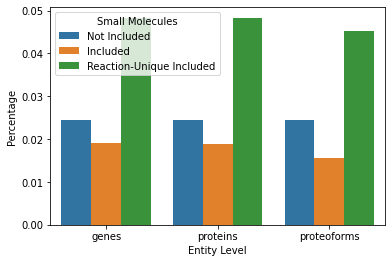

In [36]:
data = {
    "Bottleneck": ["Articulation Points"]*9,
    "Percentage": df_br_ap["Percentage of nodes that are articulation points"]
}
df_art_points = pd.DataFrame(data)
df_art_points.reset_index(inplace=True)

data = {
    "Bottleneck": ["Bridges"]*9,
    "Percentage": df_br_ap["Percentage of links that are bridges"]
}
df_bridges = pd.DataFrame(data)
df_bridges.reset_index(inplace=True)

data_br_ap = pd.concat([df_art_points, df_bridges])
data_br_ap

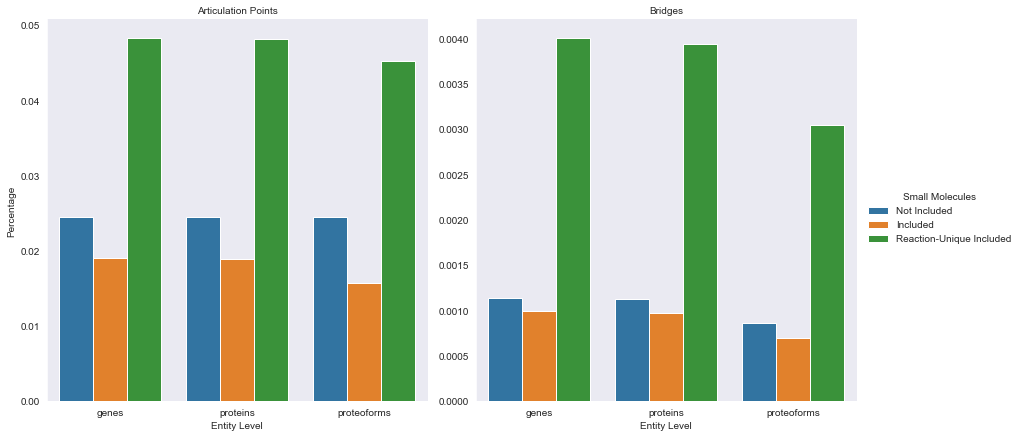

In [48]:
sns.set_style("dark")
f = sns.catplot(x="Entity Level",
                y="Percentage",
                hue = "Small Molecules",
                col= "Bottleneck",
                data=data_br_ap,
                kind="bar",
                height=6, aspect=1, sharey=False)
f.set_titles("{col_name}")


In [17]:
from lib.networks import create_pathway_interaction_networks

# Create all pathway networks
# Sets each node as node as articulation points or not
# Sets each edge as bridge or not
df_pathways = get_pathways()
#for pathway in df_pathways["stId"]:
#    create_pathway_interaction_networks(pathway, "resources/pathway_networks/")
df_pathways

,stId,displayName
0,R-HSA-9613829,Chaperone Mediated Autophagy
1,R-HSA-1632852,Macroautophagy
2,R-HSA-5205685,PINK1-PRKN Mediated Mitophagy
3,R-HSA-8934903,Receptor Mediated Mitophagy
4,R-HSA-9613354,Lipophagy
...,...,...
2060,R-HSA-432722,Golgi Associated Vesicle Biogenesis
2061,R-HSA-432720,Lysosome Vesicle Biogenesis
2062,R-HSA-8856828,Clathrin-mediated endocytosis
2063,R-HSA-8856825,Cargo recognition for clathrin-mediated endocy...


In [18]:
from lib.networks import get_json_filename, create_pathway_interaction_network, read_graph, \
    update_json_file, set_articulation_points, set_num_articulation_points, set_bridges, set_num_bridges
from config import LEVELS, METHODS
from pathlib import Path

out_path = "resources/pathway_networks/"
art_points_sequences = []
bridge_sequences = []
for method in METHODS:
    for level in LEVELS:
        art_point_sequence = []
        bridge_sequence = []
        for pathway in df_pathways["stId"]:
            #print(f"Bridges for {pathway}")
            filename = get_json_filename(level, method, out_path, pathway)
            if not Path(filename).exists():
                create_pathway_interaction_network(pathway, level, method, out_path)
            G = read_graph(filename)

            set_articulation_points(G)
            set_num_articulation_points(G)
            art_points_ratio = G.graph['Articulation Points']/G.number_of_nodes() if G.number_of_nodes() > 0 else 0
            art_point_sequence.append(art_points_ratio)

            set_bridges(G)
            set_num_bridges(G)

            bridge_ratio = G.graph['Bridges']/G.number_of_edges() if G.number_of_edges() > 0 else 0
            bridge_sequence.append(bridge_ratio)

            update_json_file(G, level, method, out_path, pathway)
        art_points_sequences.append(sorted(art_point_sequence))
        bridge_sequences.append(sorted(bridge_sequence))

art_points_sequences = pd.Series([sorted(sequence, reverse=True) for sequence in art_points_sequences], index=index)
art_points_sequences

Small Molecules           Entity Level
Not Included              genes           [0.3333333333333333, 0.3333333333333333, 0.333...
                          proteins        [0.3333333333333333, 0.3333333333333333, 0.333...
                          proteoforms     [0.5, 0.4444444444444444, 0.4, 0.4, 0.4, 0.4, ...
Included                  genes           [0.5, 0.3333333333333333, 0.3333333333333333, ...
                          proteins        [0.5, 0.3333333333333333, 0.3333333333333333, ...
                          proteoforms     [0.5, 0.4, 0.3333333333333333, 0.3333333333333...
Reaction-Unique Included  genes           [0.5, 0.42857142857142855, 0.4, 0.333333333333...
                          proteins        [0.5, 0.42857142857142855, 0.4, 0.333333333333...
                          proteoforms     [0.5, 0.42857142857142855, 0.4, 0.4, 0.375, 0....
dtype: object

In [19]:
bridge_sequences = pd.Series([sorted(sequence, reverse=True) for sequence in bridge_sequences], index=index)
bridge_sequences

Small Molecules           Entity Level
Not Included              genes           [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
                          proteins        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
                          proteoforms     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
Included                  genes           [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
                          proteins        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
                          proteoforms     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
Reaction-Unique Included  genes           [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
                          proteins        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
                          proteoforms     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
dtype: object

In [20]:
mins = pd.Series([min(art_points_sequence) for art_points_sequence in art_points_sequences], index=index)
maxs = pd.Series([max(art_points_sequence) for art_points_sequence in art_points_sequences], index=index)
avgs = pd.Series([sum(art_points_sequence)/len(art_points_sequence) for art_points_sequence in art_points_sequences], index=index)

df_art_points = pd.DataFrame({"Min": mins, "Max": maxs, "Avg": avgs}, index=index)
df_art_points.index.name = "Articulation Points"
df_art_points

Min  Max  Avg
Small Molecules          Entity Level               
Not Included             genes        0.00 0.33 0.02
                         proteins     0.00 0.33 0.02
                         proteoforms  0.00 0.50 0.03
Included                 genes        0.00 0.50 0.03
                         proteins     0.00 0.50 0.03
                         proteoforms  0.00 0.50 0.03
Reaction-Unique Included genes        0.00 0.50 0.04
                         proteins     0.00 0.50 0.04
                         proteoforms  0.00 0.50 0.03

In [21]:
mins = pd.Series([min(bridge_sequence) for bridge_sequence in bridge_sequences], index=index)
maxs = pd.Series([max(bridge_sequence) for bridge_sequence in bridge_sequences], index=index)
avgs = pd.Series([sum(bridge_sequence)/len(bridge_sequence) for bridge_sequence in bridge_sequences], index=index)

df_bridges = pd.DataFrame({"Min": mins, "Max": maxs, "Avg": avgs}, index=index)
df_bridges.index.name = "Bridges"
df_bridges

Min  Max  Avg
Small Molecules          Entity Level               
Not Included             genes        0.00 1.00 0.10
                         proteins     0.00 1.00 0.10
                         proteoforms  0.00 1.00 0.10
Included                 genes        0.00 1.00 0.07
                         proteins     0.00 1.00 0.07
                         proteoforms  0.00 1.00 0.07
Reaction-Unique Included genes        0.00 1.00 0.08
                         proteins     0.00 1.00 0.08
                         proteoforms  0.00 1.00 0.08

In [22]:
df_art_points= pd.DataFrame({"Sequence": art_points_sequences})
df_art_points.reset_index(inplace=True)
lst_col = 'Sequence'

df_art_points = pd.DataFrame({
      col:np.repeat(df_art_points[col].values, df_art_points[lst_col].str.len())
      for col in df_art_points.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(df_art_points[lst_col].values)})[df_art_points.columns]

df_art_points = df_art_points.rename(columns={'Sequence': 'Articulation Points'})
#df_art_points['Articulation Points'] = df_art_points['Articulation Points'].apply(lambda x: 0 if x == 0 else np.log10(x))

df_art_points

,Small Molecules,Entity Level,Articulation Points
0,Not Included,genes,0.33
1,Not Included,genes,0.33
2,Not Included,genes,0.33
3,Not Included,genes,0.33
4,Not Included,genes,0.33
...,...,...,...
18580,Reaction-Unique Included,proteoforms,0.00
18581,Reaction-Unique Included,proteoforms,0.00
18582,Reaction-Unique Included,proteoforms,0.00
18583,Reaction-Unique Included,proteoforms,0.00


In [23]:
#tips = sns.load_dataset("tips")
#tips

In [24]:
#ax = sns.boxplot(x="day", y="total_bill", hue="smoker", data=tips, palette="Set3")

In [25]:
from matplotlib import ticker as mticker

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
fig7 = sns.violinplot(x="Small Molecules", y="Articulation Points", hue="Entity Level", data=df_art_points, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
plt.legend(bbox_to_anchor=(1.0, 1),borderaxespad=0.5) # Put the legend out of the figure
plt.show()
fig7.figure.savefig('figures/figure_7.png')

AttributeError: module 'matplotlib' has no attribute 'subplots'

In [ ]:
df_bridges= pd.DataFrame({"Sequence": bridge_sequences})
df_bridges.reset_index(inplace=True)
lst_col = 'Sequence'

df_bridges = pd.DataFrame({
      col:np.repeat(df_bridges[col].values, df_bridges[lst_col].str.len())
      for col in df_bridges.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(df_bridges[lst_col].values)})[df_bridges.columns]

df_bridges = df_bridges.rename(columns={'Sequence': 'Bridges'})
#df_bridges['Bridges'] = df_bridges['Bridges'].apply(lambda x: 0 if x == 0 else np.log10(x))

df_bridges

In [ ]:
from matplotlib import ticker as mticker

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
fig8 = sns.violinplot(x="Small Molecules", y="Bridges", hue="Entity Level", data=df_bridges, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
plt.legend(bbox_to_anchor=(1.0, 1),borderaxespad=0.5) # Put the legend out of the figure
plt.show()
fig8.figure.savefig('figures/figure_8.png')